In [4]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *


#My image
file_path = '../Dropbox Files/hel1.pma'
image_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame.png"
image = io.imread(image_path, as_gray=True)

#Chanel image paths
CH1_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH1.png"
CH2_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH2.png"

good_peaks_1,_ = good_peak_finder(CH1_img_path)
good_peaks_2_new,_ = good_peak_finder(CH2_img_path, sigma=2, block_size=16, scaler_percent=10, boarder=10, max_rad=3)

# Move good_peaks_1 to CH2 to display full image
good_peaks_1_CH2 = shift_peaks(good_peaks_1)
good_peaks_2_CH2 = shift_peaks(good_peaks_2_new)

# Poly Mapping
CH1_peaks_10= np.array([[14, 190], [308, 10], [493, 131], [115, 168], [273, 61], [55, 59], [179, 41], [234, 157], [365, 161], [502, 43]])
CH2_peaks_10 = np.array([[18, 449], [311, 269], [492, 388], [119, 427], [276, 319], [60, 318], [183, 300], [236, 416], [364, 419], [501, 301]])

params_x_man_10, params_y_man_10 = find_polyfit_params(CH1_peaks_10, CH2_peaks_10, degree=3)
mapped_peaks_10 = apply_polyfit_params(good_peaks_1, params_x_man_10, params_y_man_10).astype(np.uint16)
poly_pair_count_tol4_10, poly_pair_arr_CH1_tol4_10, poly_pair_arr_CH2_tol4_10 = find_polyfit_pairs(mapped_peaks_10, good_peaks_1, tolerance=4)

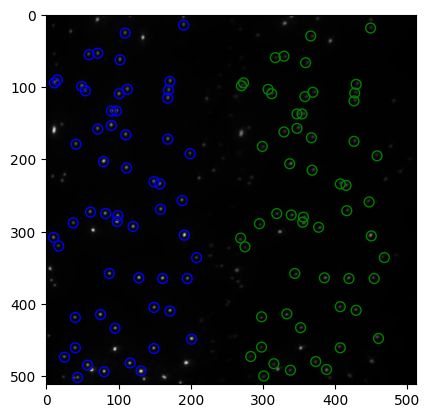

In [5]:
fig, ax = plt.subplots()
plt.imshow(image, cmap='gray')
ax.scatter(poly_pair_arr_CH1_tol4_10[:,1], poly_pair_arr_CH1_tol4_10[:,0], facecolors='none', edgecolors='b', s=50, label='CH1')
ax.scatter(poly_pair_arr_CH2_tol4_10[:,1], poly_pair_arr_CH2_tol4_10[:,0], facecolors='none', edgecolors='g', s=50, label='CH2')
plt.show()

## Remove photobleaching peaks e.g. peaks whos counterpart has an intensity of <15% 
#### Example power point says this pma file has 226 molecules, we are currently at 266!

In [6]:
circle_array_CH1 = draw_circle(4, poly_pair_arr_CH1_tol4_10[:,1], poly_pair_arr_CH1_tol4_10[:,0], image.shape[0])
circle_array_CH2 = draw_circle(4, poly_pair_arr_CH2_tol4_10[:,1], poly_pair_arr_CH2_tol4_10[:,0], image.shape[0])
circle_array_new = circle_array_CH1 + circle_array_CH2
mask_new = (circle_array_new == [255, 255, 0]).all(axis=-1)

Frames_data = read_pma(file_path)
radius = 4

for i in range(len(Frames_data)): #for i in range(795): i= 0, 1, 2,..., 794

    # transforms from 2D to 3D
    if Frames_data[i].ndim == 2:
        frame_3d = np.repeat(Frames_data[i][..., np.newaxis], 3, -1)
    elif Frames_data[i].ndim==3 and Frames_data[i].shape[2]==3:
        frame_3d = Frames_data[i]
    frame_3d[mask_new] = [255, 255, 0]

    CH1_tot_peak_intensity_all_frames = []
    for y_centre, x_centre in poly_pair_arr_CH1_tol4_10:
        x = radius
        y = 0
        total_intensity = 0
        for i in range(x_centre - radius, x_centre + radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    total_intensity += int(frame_3d[i][j][0])
        CH1_tot_peak_intensity_all_frames.append(total_intensity)

print(f"Length of CH1_tot_peak_intensity_all_frames: {len(CH1_tot_peak_intensity_all_frames)}")
print(f"Number of CH1 peaks: {len(poly_pair_arr_CH1_tol4_10)}")
print(f"These should be the same value")


Image Size: 512 x 512
Length of CH1_tot_peak_intensity_all_frames: 56
Number of CH1 peaks: 56
These should be the same value


In [7]:
print(CH1_tot_peak_intensity_all_frames[:5])

[2803, 2394, 1708, 2094, 1951]


In [10]:
print(poly_pair_arr_CH1_tol4_10[:5])
print(poly_pair_arr_CH2_tol4_10[:5])
for y_1, x_1 in poly_pair_arr_CH1_tol4_10:
    print(f"CH1: {y_1, x_1}")

[[493 131]
 [305 191]
 [494  80]
 [449 201]
 [286  98]]
[[491 388]
 [306 450]
 [492 338]
 [448 460]
 [287 355]]
CH1: (np.int64(493), np.int64(131))
CH1: (np.int64(305), np.int64(191))
CH1: (np.int64(494), np.int64(80))
CH1: (np.int64(449), np.int64(201))
CH1: (np.int64(286), np.int64(98))
CH1: (np.int64(364), np.int64(128))
CH1: (np.int64(203), np.int64(79))
CH1: (np.int64(365), np.int64(161))
CH1: (np.int64(415), np.int64(75))
CH1: (np.int64(482), np.int64(116))
CH1: (np.int64(485), np.int64(57))
CH1: (np.int64(410), np.int64(171))
CH1: (np.int64(462), np.int64(149))
CH1: (np.int64(434), np.int64(95))
CH1: (np.int64(293), np.int64(120))
CH1: (np.int64(275), np.int64(82))
CH1: (np.int64(153), np.int64(90))
CH1: (np.int64(405), np.int64(149))
CH1: (np.int64(212), np.int64(111))
CH1: (np.int64(358), np.int64(87))
CH1: (np.int64(234), np.int64(157))
CH1: (np.int64(278), np.int64(99))
CH1: (np.int64(365), np.int64(195))
CH1: (np.int64(133), np.int64(90))
CH1: (np.int64(461), np.int64(40))
